In [ ]:
!pip install evaluate --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00


In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from transformers import AutoTokenizer, AutoModel

import warnings
warnings.filterwarnings('ignore')

In [126]:
df = pd.read_csv('/content/TalkFile_ner_2.csv').iloc[:700,:]
print(f"df.shape: {df.shape}")

df.shape: (700, 4)


In [127]:
df['Tag'] = df['Tag'].apply(lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)
df.head()

,Sentence #,Sentence,POS,Tag
0,Sentence: 1,Thousands of demonstrators have marched throug...,"['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP'...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo..."
1,Sentence: 2,Families of soldiers killed in the conflict jo...,"['NNS', 'IN', 'NNS', 'VBN', 'IN', 'DT', 'NN', ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,Sentence: 3,They marched from the Houses of Parliament to ...,"['PRP', 'VBD', 'IN', 'DT', 'NNS', 'IN', 'NN', ...","[O, O, O, O, O, O, O, O, O, O, O, B-geo, I-geo..."
3,Sentence: 4,"Police put the number of marchers at 10,000 wh...","['NNS', 'VBD', 'DT', 'NN', 'IN', 'NNS', 'IN', ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
4,Sentence: 5,The protest comes on the eve of the annual con...,"['DT', 'NN', 'VBZ', 'IN', 'DT', 'NN', 'IN', 'D...","[O, O, O, O, O, O, O, O, O, O, O, B-geo, O, O,..."


In [128]:
le = LabelEncoder()
all_tags = [tag for sublist in df['Tag'] for tag in sublist]
unique_tags = list(set(all_tags))
unique_tags_sorted = sorted(unique_tags, reverse=True)

le.fit(unique_tags_sorted)
df['Tag_Encoded'] = df['Tag'].apply(lambda x: le.transform(x).tolist())
tag_to_id = {tag: id for id, tag in enumerate(le.classes_)}

In [129]:
new_df = df[['Sentence', 'Tag_Encoded']]
new_df.head(2)

,Sentence,Tag_Encoded
0,Thousands of demonstrators have marched throug...,"[16, 16, 16, 16, 16, 16, 2, 16, 16, 16, 16, 16..."
1,Families of soldiers killed in the conflict jo...,"[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 1..."


In [130]:
import re
def clean_text(line):
    line = re.sub(r'-+',' ',line)
    line = re.sub(r'[^a-zA-Z, ]+'," ",line)
    line = re.sub(r'[ ]+'," ",line)
    line += "."
    return line

text_list = []
len_list = []

for line in df['Sentence'].tolist():
  line = clean_text(line)
  text_list.append(line)
  len_list.append(len(line.split(" ")))

In [131]:
max_len = 0
for i in text_list:
  max_len = max(max_len, len(i))
print(max_len)

276


In [132]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
inputs = tokenizer(text_list, max_length = max_len, truncation = True, padding = 'max_length', return_tensors = 'pt')

In [133]:
vocab_size = len(tokenizer.vocab)
num_samples = inputs['input_ids'].shape[0]
seq_length = inputs['input_ids'].shape[1]
print(f"Vocabulary size: {vocab_size}")
print(f"Number of samples: {num_samples}")
print(f"Sequence length: {seq_length}")

Vocabulary size: 30522
Number of samples: 700
Sequence length: 276


In [134]:
vocab_size = 30522
embedding_dim = 300
hidden_dim = 128
n_layers = 2
bidirectional = True
dropout = 0.5
pad_index = 0

lr = 1e-4
batch_size = 50
max_document_length = 100
dev_size = 0.8
max_size = 5000
seed = 1
num_epochs = 7

In [103]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, bidirectional, dropout, pad_index):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)  # 첫 번째
        self.fc2 = nn.Linear(hidden_dim * 2, hidden_dim)  # 두 번째
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = pack_padded_sequence(embedded, text_lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        output1 = self.fc1(hidden)
        output2 = self.fc2(hidden)
        return self.dropout(output1), self.dropout(output2)

class SiameseNetwork(nn.Module):
    def __init__(self, base_model):
        super(SiameseNetwork, self).__init__()
        self.encoder = base_model

    def forward(self, x1, lengths1, x2, lengths2):
        h1_forward, h1_backward = self.encoder(x1, lengths1)
        h2_forward, h2_backward = self.encoder(x2, lengths2)
        return h1_forward, h1_backward, h2_forward, h2_backward

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, outputs1, outputs2, labels):
        euclidean_distance = F.pairwise_distance(outputs1, outputs2, keepdim=True)
        loss_contrastive = torch.mean((1 - labels) * torch.pow(euclidean_distance, 2) +
                                      (labels) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [135]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, bidirectional, dropout, pad_index):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.embedding(text['input_ids'])
        packed_embedded = pack_padded_sequence(embedded, text['attention_mask'].sum(dim=1), batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        output = self.fc(hidden)
        return self.dropout(output)



class SiameseNetwork(nn.Module):
    def __init__(self, base_model):
        super(SiameseNetwork, self).__init__()
        self.encoder = base_model

    def forward(self, x1, x2):
        output1 = self.encoder(x1)
        output2 = self.encoder(x2)
        return output1, output2



class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, outputs1, outputs2, labels):
        euclidean_distance = F.pairwise_distance(outputs1, outputs2, keepdim=True)
        loss_contrastive = torch.mean((1 - labels) * torch.pow(euclidean_distance, 2) +
                                      (labels) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [136]:
base_model = Encoder(vocab_size, embedding_dim, hidden_dim, n_layers, bidirectional, dropout, pad_index)
siamese_model = SiameseNetwork(base_model)

In [137]:
siamese_model

SiameseNetwork(
  (encoder): Encoder(
    (embedding): Embedding(30522, 300, padding_idx=0)
    (lstm): LSTM(300, 128, num_layers=2, batch_first=True, bidirectional=True)
    (fc): Linear(in_features=256, out_features=128, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

# Cosine Similarity using T5

In [138]:
from transformers import T5Tokenizer, T5EncoderModel

model_name = 't5-small'
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5EncoderModel.from_pretrained(model_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [139]:
def get_sentence_embedding(sentence, tokenizer, model):
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

def compute_cosine_similarity(embedding1, embedding2):
    return cosine_similarity(embedding1, embedding2)[0][0]

In [144]:
def generate_labeled_pairs(df, threshold=0.63):
    labeled_pairs = []
    for i in range(len(df)):
        anchor_sentence = df.iloc[i]['Sentence']
        anchor_embedding = get_sentence_embedding(anchor_sentence, tokenizer, model)

        # Choose random sentence
        random_idx = random.randint(0, len(df) - 1)
        while random_idx == i:  # Prevent choosing same index
            random_idx = random.randint(0, len(df) - 1)
        random_sentence = df.iloc[random_idx]['Sentence']
        random_embedding = get_sentence_embedding(random_sentence, tokenizer, model)

        # Calculate cosine similarity
        similarity = compute_cosine_similarity(anchor_embedding, random_embedding)

        label = 1 if similarity >= threshold else 0
        labeled_pairs.append((anchor_sentence, random_sentence, label))

    return labeled_pairs

In [143]:
for i in [0.4, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]:
  labeled_pairs = generate_labeled_pairs(new_df, threshold=i)
  labeled_df = pd.DataFrame(labeled_pairs, columns=['Anchor', 'Random_Sentence', 'Label'])

  positive_count = labeled_df['Label'].sum()
  negative_count = len(labeled_df) - positive_count
  print(f"threshold : {i}, Positive: {positive_count}, Negative: {negative_count}")

threshold : 0.4, Positive: 700, Negative: 0
threshold : 0.5, Positive: 667, Negative: 33
threshold : 0.55, Positive: 574, Negative: 126
threshold : 0.6, Positive: 457, Negative: 243
threshold : 0.65, Positive: 260, Negative: 440
threshold : 0.7, Positive: 83, Negative: 617
threshold : 0.75, Positive: 25, Negative: 675
threshold : 0.8, Positive: 4, Negative: 696


In [145]:
labeled_pairs = generate_labeled_pairs(new_df)
labeled_df = pd.DataFrame(labeled_pairs, columns=['Anchor', 'Random_Sentence', 'Label'])

In [146]:
positive_count = labeled_df['Label'].sum()
negative_count = len(labeled_df) - positive_count
print(f"Positive: {positive_count}, Negative: {negative_count}")

Positive: 330, Negative: 370


In [147]:
labeled_df.head()

,Anchor,Random_Sentence,Label
0,Thousands of demonstrators have marched throug...,"He succeeds Lawrence Summers , another top eco...",0
1,Families of soldiers killed in the conflict jo...,Aigle Azur is just one of a number of airlines...,0
2,They marched from the Houses of Parliament to ...,At least one Kenyan was wounded Friday when pr...,1
3,"Police put the number of marchers at 10,000 wh...",WHO says they are receiving treatment and are ...,0
4,The protest comes on the eve of the annual con...,Indonesian police have arrested three men in c...,0


In [148]:
labeled_df.to_csv('/content/labeled_data.csv')

In [149]:
class SiameseDataset(Dataset):
    def __init__(self, Anchor, Random_Sentence, Label):
        self.text1 = Anchor
        self.text2 = Random_Sentence
        self.labels = Label

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text1 = self.text1[idx]
        text2 = self.text2[idx]
        label = self.labels[idx]
        return text1, text2, torch.tensor(label)

# Train Test

In [150]:
train_df, test_df = train_test_split(labeled_df, test_size=0.2, random_state=42)

train_dataset = SiameseDataset(train_df["Anchor"].tolist(), train_df["Random_Sentence"].tolist(), train_df["Label"].tolist())
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = SiameseDataset(test_df["Anchor"].tolist(), test_df["Random_Sentence"].tolist(), test_df["Label"].tolist())
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [151]:
optimizer = optim.Adam(siamese_model.parameters(), lr=1e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model.to(device)
siamese_model.to(device)
print(device)

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
criterion = ContrastiveLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 10

cpu


# Modeling

In [152]:
for epoch in range(num_epochs):
    total_loss = 0
    for text1, text2, labels in train_loader:

        inputs1 = tokenizer(text1, padding="max_length", truncation=True, max_length=max_len, return_tensors="pt")
        inputs2 = tokenizer(text2, padding="max_length", truncation=True, max_length=max_len, return_tensors="pt")

        inputs1 = inputs1.to(device)
        inputs2 = inputs2.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs1, outputs2 = siamese_model(inputs1, inputs2)
        loss = criterion(outputs1, outputs2, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {avg_loss:.4f}")

Epoch 1/10 - Average Loss: 0.3703
Epoch 2/10 - Average Loss: 0.3056
Epoch 3/10 - Average Loss: 0.2754
Epoch 4/10 - Average Loss: 0.2658
Epoch 5/10 - Average Loss: 0.2655
Epoch 6/10 - Average Loss: 0.2642
Epoch 7/10 - Average Loss: 0.2633
Epoch 8/10 - Average Loss: 0.2633
Epoch 9/10 - Average Loss: 0.2631
Epoch 10/10 - Average Loss: 0.2617


In [153]:
siamese_model.eval()
predictions = []

with torch.no_grad():
    for text1, text2, labels in test_loader:

        inputs1 = tokenizer(text1, padding="max_length", truncation=True, max_length=max_len, return_tensors="pt")
        inputs2 = tokenizer(text2, padding="max_length", truncation=True, max_length=max_len, return_tensors="pt")

        inputs1 = inputs1.to(device)
        inputs2 = inputs2.to(device)

        outputs1, outputs2 = siamese_model(inputs1, inputs2)
        distances = torch.nn.functional.pairwise_distance(outputs1, outputs2)
        predictions.extend(distances.cpu().numpy())

In [154]:
test_df['predicted_labels'] = predictions
print(test_df[test_df['Label']==1]['predicted_labels'].mean(), test_df[test_df['Label']==0]['predicted_labels'].mean())

0.26187187 0.2635265


In [155]:
test_df.head()

,Anchor,Random_Sentence,Label,predicted_labels
158,They were convicted of plotting to kill Mr. Ca...,Israeli soldiers killed five Palestinians Thur...,1,0.270637
500,Some human rights groups rejected the changes ...,The New Jersey jurists agreed with Merck that ...,1,0.260685
396,The disgraced ex-president and son of Japanese...,Five bomb attacks were carried out in Baghdad .,0,0.237901
155,The countries agreed to reopen their consulate...,They said the rescuers were trying to recover ...,0,0.247677
321,"But a Ugandan High Court Judge , John Bosco Ka...",Pakistani Prime Minister Yusuf Raza Gilani con...,1,0.285919


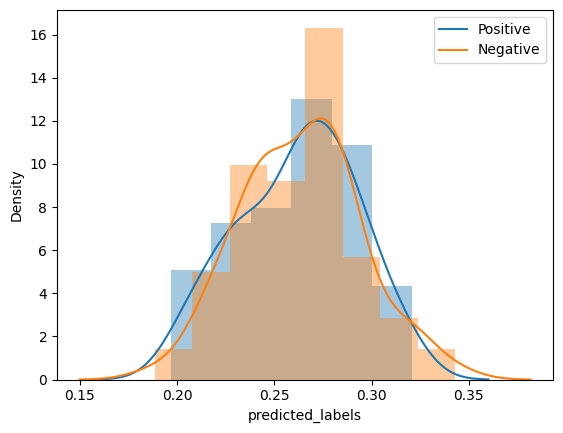

In [156]:
sns.distplot(test_df[test_df['Label']==1]['predicted_labels'])
sns.distplot(test_df[test_df['Label']==0]['predicted_labels'])
plt.legend(['Positive', 'Negative'])
plt.show()

# Fine tune model

In [157]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, bidirectional, dropout, pad_index):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, batch_first=True)
        self.output_dim = hidden_dim
        self.fc = nn.Linear(hidden_dim * 2, self.output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.embedding(text['input_ids'])
        packed_embedded = pack_padded_sequence(embedded, text['attention_mask'].sum(dim=1), batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        output = self.fc(hidden)
        output = self.dropout(output)
        return output

class FineTunedSiameseNetwork(nn.Module):
    def __init__(self, base_model):
        super(FineTunedSiameseNetwork, self).__init__()
        self.base_model = base_model
        # Assuming the base_model outputs a feature vector of size output_dim
        self.linear = nn.Linear(base_model.output_dim, base_model.output_dim)

    def forward(self, x1, x2):
        # Apply the base model to each input to get the embeddings
        # The output here assumes that base_model returns the output tensor directly
        output1 = self.base_model(x1)
        output2 = self.base_model(x2)
        # Apply the new linear layer to these outputs
        output1 = self.linear(output1)
        output2 = self.linear(output2)

        return output1, output2

In [158]:
base_model = Encoder(vocab_size, embedding_dim, hidden_dim, n_layers, bidirectional, dropout, pad_index)
siamese_model_fine = FineTunedSiameseNetwork(base_model)

In [159]:
siamese_model_fine

FineTunedSiameseNetwork(
  (base_model): Encoder(
    (embedding): Embedding(30522, 300, padding_idx=0)
    (lstm): LSTM(300, 128, num_layers=2, batch_first=True, bidirectional=True)
    (fc): Linear(in_features=256, out_features=128, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (linear): Linear(in_features=128, out_features=128, bias=True)
)

In [160]:
for epoch in range(num_epochs):
    total_loss = 0
    for text1, text2, labels in train_loader:

        inputs1 = tokenizer(text1, padding="max_length", truncation=True, max_length=max_len, return_tensors="pt")
        inputs2 = tokenizer(text2, padding="max_length", truncation=True, max_length=max_len, return_tensors="pt")

        inputs1 = inputs1.to(device)
        inputs2 = inputs2.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs1, outputs2 = siamese_model_fine(inputs1, inputs2)
        loss = criterion(outputs1, outputs2, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {avg_loss:.4f}")

Epoch 1/10 - Average Loss: 0.2533
Epoch 2/10 - Average Loss: 0.2526
Epoch 3/10 - Average Loss: 0.2537
Epoch 4/10 - Average Loss: 0.2525
Epoch 5/10 - Average Loss: 0.2527
Epoch 6/10 - Average Loss: 0.2522
Epoch 7/10 - Average Loss: 0.2540
Epoch 8/10 - Average Loss: 0.2529
Epoch 9/10 - Average Loss: 0.2531
Epoch 10/10 - Average Loss: 0.2534


In [161]:
siamese_model_fine.eval()
predictions = []

with torch.no_grad():
    for text1, text2, labels in test_loader:

        inputs1 = tokenizer(text1, padding="max_length", truncation=True, max_length=max_len, return_tensors="pt")
        inputs2 = tokenizer(text2, padding="max_length", truncation=True, max_length=max_len, return_tensors="pt")

        inputs1 = inputs1.to(device)
        inputs2 = inputs2.to(device)

        outputs1, outputs2 = siamese_model_fine(inputs1, inputs2)
        distances = torch.nn.functional.pairwise_distance(outputs1, outputs2)
        predictions.extend(distances.cpu().numpy())

In [162]:
test_df2 = test_df.copy()

In [163]:
test_df2['fine_tune'] = predictions
print(test_df2[test_df2['Label']==1]['fine_tune'].mean(), test_df2[test_df2['Label']==0]['fine_tune'].mean())

0.16037434 0.1671962


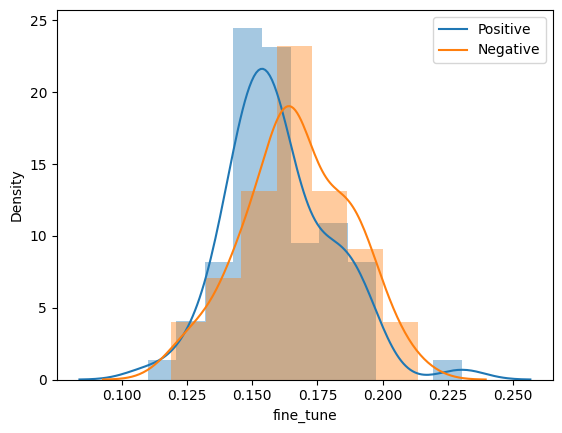

In [164]:
sns.distplot(test_df2[test_df2['Label']==1]['fine_tune'])
sns.distplot(test_df2[test_df2['Label']==0]['fine_tune'])
plt.legend(['Positive', 'Negative'])
plt.show()

# Gini

In [165]:
def calculate_gini_coefficient(predictions):
    predictions = np.array(predictions)
    n = predictions.size
    lorenz_curve = np.cumsum(np.sort(predictions)) / predictions.sum()
    lorenz_curve = np.insert(lorenz_curve, 0, 0)
    gini_index = 1 - 2 * np.trapz(lorenz_curve, np.linspace(0, 1, n+1))
    return gini_index

In [166]:
Without_Finetune = np.array(test_df2['predicted_labels'])
With_Finetune = np.array(test_df2['fine_tune'])

In [167]:
gini_without_finetune = calculate_gini_coefficient(Without_Finetune)
gini_with_finetune = calculate_gini_coefficient(With_Finetune)

In [168]:
print('Gini without finetune', gini_without_finetune)
print('Gini with finetune', gini_with_finetune)

Gini without finetune 0.0653670182518129
Gini with finetune 0.07015324210348939
